#**Self-driving Challenge**

# 1. Introduction




We employ a system that is entirely dependent on vision in order to guide a vehicle as it its moving
down the road. The primary objective of this technique is to instruct the deep model to grasp the
steering angles in conjunction with the specified speed and images based on the practical knowledge
of an experienced driver.The training includes the following:



1.   Data collection, which is to acquire good commands(labels) from human drivers
2.   Model training, which is to clone the behavior of human drivers

Currently, there are two types of road conditions(easy vs hard). In order to successfully complete the
midterm exam, each group will need to train a vision model and then assess the trained model’s ability
to run on the challenging path. TA has compiled the course code and created a sample model, both
of which can be seen on google drive and are accessible to the public.

Program download link: https://github.com/udacity/self-driving-car-sim

Tips:



1.   To explicitly model steering angle based on inputs
2.   To explicitly model speed based on inputs
3.   Find a good driver
4.   Read the sample code carefully first

Rubric:

C ≤ 45 sec. 45sec < B < 1 loop. A >= 1 loop.




# 2. Build and train the model

The IMG folder and driving_log.csv were in /data folder, you can modify the code, or create a /data folder and choose it as recording destination.

data
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 66, 200, 3)        0         
                                                                 
 conv2d (Conv2D)             (None, 31, 98, 24)        1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 20, 64)         27712     
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 18, 64)         36928     
                                                                 
 dropout (Dropout)           (None, 1, 18, 64)     

C:\Users\Quinn Leydon\AppData\Local\Temp\ipykernel_35184\2878211297.py:318: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(self.batch_generator(X_train, y_train, True),


Epoch 1/10
300/300 [==============================] - 397s 1s/step - loss: 0.0993 - val_loss: 0.0481
Epoch 2/10
  1/300 [..............................] - ETA: 30s - loss: 0.0955

c:\Users\Quinn Leydon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


300/300 [==============================] - 339s 1s/step - loss: 0.0731 - val_loss: 0.0420
Epoch 3/10
300/300 [==============================] - 318s 1s/step - loss: 0.0647 - val_loss: 0.0378
Epoch 4/10
300/300 [==============================] - 311s 1s/step - loss: 0.0605 - val_loss: 0.0396
Epoch 5/10
300/300 [==============================] - 310s 1s/step - loss: 0.0593 - val_loss: 0.0433
Epoch 6/10
300/300 [==============================] - 308s 1s/step - loss: 0.0561 - val_loss: 0.0371
Epoch 7/10
300/300 [==============================] - 303s 1s/step - loss: 0.0554 - val_loss: 0.0370
Epoch 8/10
300/300 [==============================] - 298s 997ms/step - loss: 0.0547 - val_loss: 0.0380
Epoch 9/10
300/300 [==============================] - 285s 954ms/step - loss: 0.0542 - val_loss: 0.0368
Epoch 10/10
300/300 [==============================] - 262s 875ms/step - loss: 0.0521 - val_loss: 0.0358


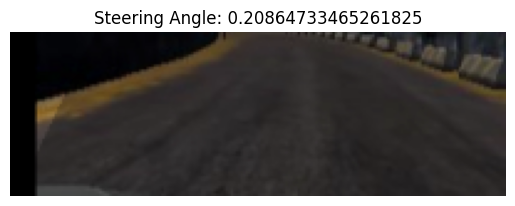

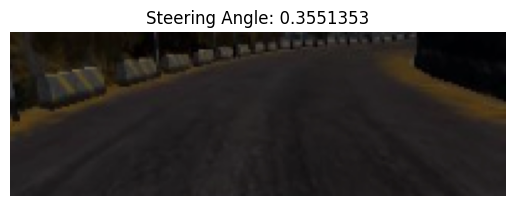

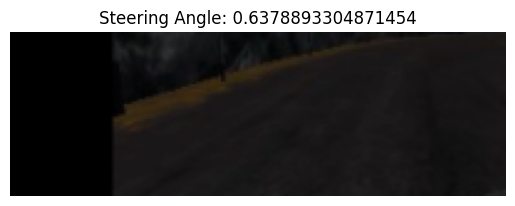

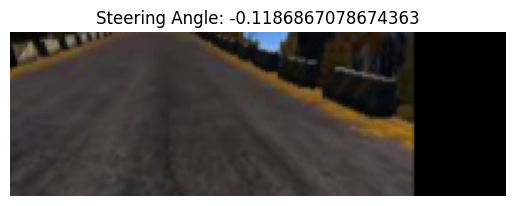

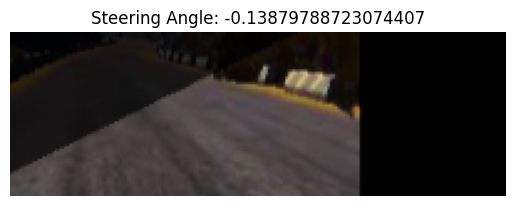

In [2]:
# -*- coding: utf-8 -*-
import pandas as pd
import cv2, os
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Lambda, Conv2D, Dropout, Dense, Flatten
from keras.callbacks import ModelCheckpoint
import numpy as np
import matplotlib.image as mpimg
from keras.optimizers import Adam
from keras.models import load_model

import matplotlib.pyplot as plt


class PowerMode_autopilot:

    def __init__(self, data_path='simulator-windows-64/Data2', learning_rate=1.0e-4, keep_prob=0.5, batch_size=40,
                 save_best_only=True, test_size=0.2, steps_per_epoch=20000, epochs=10):
        self.IMAGE_HEIGHT, self.IMAGE_WIDTH, self.IMAGE_CHANNELS = 66, 200, 3
        self.data_path = data_path
        self.learning_rate = learning_rate
        self.keep_prob = keep_prob
        self.save_best_only = save_best_only
        self.batch_size = batch_size
        self.test_size = test_size
        self.steps_per_epoch = steps_per_epoch
        self.epochs = epochs

    def load_data(self):
        """
        Read data from driving_log.csv file, then split the data into training set and validation set,
        For every piece of data,
        X represents images of left, center, right cameras
        y represents steering value, as reference
        :return: training sets and validation sets of images and steering value
        """
        data_df = pd.read_csv(os.path.join(os.getcwd(), self.data_path, 'driving_log_2.csv')
                              , names=['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed'])
        X = data_df[['center', 'left', 'right']].values
        y = data_df['steering'].values
        # split the whole data into training and validation set RANDOMLY
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=self.test_size, random_state=0)
        return X_train, X_valid, y_train, y_valid

    def build_model(self):
        """
        build a model using keras.Sequential function
        :return: the model
        """
        model = Sequential()

        # normalization layer, converts value range [0, 255] to range [-1, 1].
        # Since it's the first layer in the model, argument input_shape must be specified
        model.add(
            Lambda(lambda x: x / 127.5 - 1.0, input_shape=(self.IMAGE_HEIGHT, self.IMAGE_WIDTH, self.IMAGE_CHANNELS)))

        # five 2D convolution layers, 'elu' means Exponential Linear Unit function
        model.add(Conv2D(24, (5, 5), activation='elu', strides=2))
        model.add(Conv2D(36, (5, 5), activation='elu', strides=2))
        model.add(Conv2D(48, (5, 5), activation='elu', strides=2))
        model.add(Conv2D(64, (3, 3), activation='elu'))
        model.add(Conv2D(64, (3, 3), activation='elu'))

        # dropout layer, sets input units to 0 with a frequency of keep_prob var, to help prevent overfitting
        model.add(Dropout(self.keep_prob))

        # three fully-connected layers and output layer after flattening
        model.add(Flatten())
        model.add(Dense(100, activation='elu'))
        model.add(Dense(50, activation='elu'))
        model.add(Dense(10, activation='elu'))
        model.add(Dense(1))
        model.summary()
        return model

    def load_image(self, image_file):
        """
        read an image file
        :param image_file: image file name
        :return: the array representing the image
        """
        return mpimg.imread(os.path.join(self.data_path, image_file.strip()))

    """
    augment image
    """

    def augment(self, center, left, right, steering_angle, range_x=200, range_y=20):
        """
        image augmentation using following functions
        :param center:
        :param left:
        :param right:
        :param steering_angle:
        :param range_x:
        :param range_y:
        :return:
        """
        image, steering_angle = self.choose_image(center, left, right, steering_angle)
        image, steering_angle = self.random_flip(image, steering_angle)
        image, steering_angle = self.random_translate(image, steering_angle, range_x, range_y)
        image = self.random_shadow(image)
        image = self.random_brightness(image)
        image = self.add_gaussian_noise(image)
        random_angle = self.random_angle(steering_angle)  

        return image, steering_angle

    def choose_image(self, center, left, right, steering_angle):
        """
        randomly choose an image: center, left, or right
        in case of left image or right image, steering angle needs to be adjusted accordingly
        :param center:
        :param left:
        :param right: images to choose from
        :param steering_angle:
        :return: result of choosing
        """
        choice = np.random.choice(3)
        if choice == 0:
            return self.load_image(left), steering_angle + 0.2
        elif choice == 1:
            return self.load_image(right), steering_angle - 0.2
        return self.load_image(center), steering_angle

    def random_flip(self, image, steering_angle):
        """
        randomly flip the image and invert steering angle accordingly or not,
        in case one direction steering happens way more than the other direction,
        which could lead to lack of training data diversity
        :param image:
        :param steering_angle:
        :return: image after flip
        """
        if np.random.rand() < 0.5:
            image = cv2.flip(image, 1)
            steering_angle = -steering_angle
        return image, steering_angle

    def random_translate(self, image, steering_angle, range_x, range_y):
        """
        translate the image horizontally and vertically, randomly.
        modify the steering angle accordingly
        :param image:
        :param steering_angle:
        :param range_x:
        :param range_y:
        :return:
        """
        if np.random.rand() < 0.9:
            # getting a transformation matrix, trans_x and trans_y denote horizontal and vertical shift value
            trans_x = range_x * (np.random.rand() - 0.5)
            trans_y = range_y * (np.random.rand() - 0.5)
            steering_angle += trans_x * 0.002
            trans_m = np.float32([[1, 0, trans_x], [0, 1, trans_y]])

            height, width = image.shape[:2]
            image = cv2.warpAffine(image, trans_m, (width, height))
        return image, steering_angle

    def random_angle(self, steering_angle):
        """
        Scale the steering angle.
        durring training the steering angle is a little conservative
        """
        if np.random.rand() < 0.5:
            steering_angle = steering_angle * (1+np.random.beta(2,3) * 0.1) # added
        return steering_angle

    def random_shadow(self, image):
        """
        add some random shadow because there are different light conditions in different situations
        :param image:
        :return:
        """
        # get the range of the shadow
        x1, y1 = self.IMAGE_WIDTH * np.random.rand(), 0
        x2, y2 = self.IMAGE_WIDTH * np.random.rand(), self.IMAGE_HEIGHT

        xm, ym = np.mgrid[0:image.shape[0], 0:image.shape[1]]

        mask = np.zeros_like(image[:, :, 1])
        mask[(ym - y1) * (x2 - x1) - (y2 - y1) * (xm - x1) > 0] = 1

        cond = mask == np.random.randint(2)
        s_ratio = np.random.uniform(low=0.2, high=0.8) #changed

        hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        hls[:, :, 1][cond] = hls[:, :, 1][cond] * s_ratio
        return cv2.cvtColor(hls, cv2.COLOR_HLS2RGB)

    def random_brightness(self, image):
        """
        adjust image brightness randomly
        convert the image to HSV model to adjust brightness more easily
        :param image:
        :return:
        """
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        ratio_h = 1.0 + 0.6 * (np.random.rand() - 0.5)
        ratio_s = 1.0 + 0.6 * (np.random.rand() - 0.5)
        ratio_v = 1.0 + 0.8 * (np.random.rand() - 0.5)
        if np.random.rand() < 0.5:
            hsv[:, :, 0] = hsv[:, :, 0] * ratio_h
        if np.random.rand() < 0.5:
            hsv[:, :, 1] = hsv[:, :, 1] * ratio_s
        if np.random.rand() < 0.5:
            hsv[:, :, 2] = hsv[:, :, 2] * ratio_v
        return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    
    def add_gaussian_noise(self, image, mean=0, std=0.2):
        noise = np.random.normal(mean, std, image.shape).astype(np.uint8)
        noisy_image = cv2.add(image, noise)
        return noisy_image
    
    """
    preprocess image
    """

    def preprocess(self, image):
        """
        preprocess the image, using the following functions
        :param image:
        :return:
        """
        image = self.crop(image)
        image = self.resize(image)
        image = self.rgb2yuv(image)
        return image

    def crop(self, image):
        """
        crop the image, keep the pixels between 60 from top and 25 from bottom,
        to get rid of the sky and the car itself, focus on the road
        :param image:
        :return:
        """
        return image[60:-25, :, :]

    def resize(self, image):
        """
        resize the image, using cv2.INTER_AREA as interpolation since we are shrinking the image
        :param image:
        :return:
        """
        return cv2.resize(image, (self.IMAGE_WIDTH, self.IMAGE_HEIGHT), cv2.INTER_AREA)

    def rgb2yuv(self, image):
        """
        convert the image from RGB format to YUV format
        :param image:
        :return:
        """
        return cv2.cvtColor(image, cv2.COLOR_RGB2YUV)

    """
    generate the training data (images and steering angles)
    """

    def batch_generator(self, image_paths, steering_angles, is_training):
        """
        generate a batch of training images and corresponding steering angles
        :param image_paths:
        :param steering_angles:
        :param is_training:
        :return:
        """
        # initialize a batch of images and steering angles with random values (faster than set all initial values to 0s)
        images = np.empty([self.batch_size, self.IMAGE_HEIGHT, self.IMAGE_WIDTH, self.IMAGE_CHANNELS])
        steers = np.empty(self.batch_size)
        while True:
            i = 0
            for index in np.random.permutation(image_paths.shape[0]):
                center, left, right = image_paths[index]
                steering_angle = steering_angles[index]
                # enhance the images with probability of 0.6
                if is_training and np.random.rand() < 0.75:
                    image, steering_angle = self.augment(center, left, right, steering_angle)
                else:
                    image = self.load_image(center)
                    
                # add the processed images and steering angle to the batch
                images[i] = self.preprocess(image)
                steers[i] = steering_angle
                i += 1
                # finish when the batch is filled
                if i == self.batch_size:
                    break
            yield images, steers

    """
    train the model
    """

    def train_model(self, model, X_train, X_valid, y_train, y_valid):
        """
        train the model
        :param model:
        :param X_train:
        :param X_valid:
        :param y_train:
        :param y_valid:
        :return:
        """
        # save model data after each epoch
        checkpoint = ModelCheckpoint('model-{epoch:03d}.h5',
                                     monitor='val_loss',
                                     verbose=0,
                                     # if save_vest_only is True, The model data with the best recent validation
                                     # error will be saved
                                     save_best_only=self.save_best_only,
                                     mode='auto')

        model.compile(loss='mean_squared_error', optimizer=Adam(lr=self.learning_rate))

        # CPU does the real-time data enhancement of the image, and the model is trained in GPU in parallel
        model.fit_generator(self.batch_generator(X_train, y_train, True),
                            steps_per_epoch=self.steps_per_epoch,
                            epochs=self.epochs,
                            # max_queue_size=1,
                            validation_data=self.batch_generator(X_valid, y_valid, False),
                            validation_steps=len(X_valid),
                            callbacks=[checkpoint],
                            verbose=1)
        
    def sample_and_display_image(self, image_path, steering_angle):
        image = cv2.imread(os.path.join(self.data_path, image_path))
        image = self.preprocess(image)
        if image is not None:
            # Display the image using OpenCV
            print(steering_angle)
            cv2.imshow('Sampled Image', image)
            
            range_x=100
            range_y=10
            image, steering_angle = self.random_flip(image, steering_angle)
            image, steering_angle = self.random_translate(image, steering_angle, range_x, range_y)
            image = self.random_shadow(image)
            image = self.random_brightness(image)
            cv2.imshow('Augmented Image', image)

            cv2.waitKey(0)  # Wait for a key press to close the image window
            cv2.destroyAllWindows()
        else:
            print(f"Image not found at path: {os.path.join(self.data_path, image_path.strip())}")


    def view_training_images(self, num_samples=5):
        """
        View preprocessed and augmented training images along with their corresponding steering angles.
        :param num_samples: The number of training samples to view.
        """
        X_train, _, y_train, _ = self.load_data()  # Load training data
        samples = np.random.choice(len(X_train), num_samples, replace=False)  # Randomly select samples

        for index in samples:
            center, left, right = X_train[index]
            steering_angle = y_train[index]
            
            # Augment the image
            image, steering_angle = self.augment(center, left, right, steering_angle)
            #image, steering_angle = self.choose_image(center, left, right, steering_angle)

            # Preprocess the image
            preprocessed_image = self.preprocess(image)
            
            # Display the preprocessed and augmented image along with the steering angle
            plt.figure()
            plt.imshow(cv2.cvtColor(preprocessed_image, cv2.COLOR_YUV2RGB))  # Convert to RGB for display
            #plt.imshow(preprocessed_image)  # Convert to RGB for display
            plt.title(f"Steering Angle: {steering_angle}")
            plt.axis('off')
            plt.show()


def main():
    autopilot = PowerMode_autopilot(data_path='simulator-windows-64/Data2', learning_rate=1.0e-4, keep_prob=0.5, batch_size=100,
                                    save_best_only=False, test_size=0.3, steps_per_epoch=300, epochs=10)
    data = autopilot.load_data()
    print('data')

    model = autopilot.build_model()

    autopilot.train_model(model, *data)

    # Sample and display an image from the dataset
    '''sample_index = 1000  # You can change this to any index you want to sample
    if sample_index < len(data[0]):  # Check if the index is within the dataset size
        image_path = data[0][sample_index][0]  # Assuming you want to display the center camera image
        steering_angle = data[2][sample_index]
        autopilot.sample_and_display_image(image_path, steering_angle)
    else:
        print("Invalid sample_index.")'''
    
    # View preprocessed and augmented training images
    num_samples = 5  # You can change this to view a different number of samples
    autopilot.view_training_images(num_samples)


if __name__ == '__main__':
    main()


In [7]:
import tensorflow as tf

# -*- coding: utf-8 -*-
import pandas as pd
import cv2, os
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Lambda, Conv2D, Dropout, Dense, Flatten
from keras.callbacks import ModelCheckpoint
import numpy as np
import matplotlib.image as mpimg
from keras.optimizers import Adam
from keras.models import load_model

tf.test.gpu_device_name()
print(keras. __version__)

2.13.1


In [38]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


# 3. Test in autopilot mode

**IMPORTANT**

Recommend to copy the file to your local space, Colab can't connect to local game process, and name your file test.py (you can name it whatever you like, test.py is just for the consistency with section 4 Game Example.)

The game process is using port #4567, don't modify it

To run this file, you need socketio library and engineio library, (and other library as you can see, of course). However, 'socketio' and 'engineio' won't work here, you will also need 'python-socketio' and 'python-engineio' libraries.

'python-socketio' version must be < 4.3, I'm using version 4.2.1

'python-engineio' version must be < 3.9, I'm using version 3.8.2.post1

My python version is 3.9, these two libraries work fine for me.

<img src="https://drive.google.com/uc?export=view&id=198bf11ALr-b9ZbnkvI0v6VXfcLEFpjDC" width=600>

Please feel free to contact me if there's any connection error.

In [4]:
# -*- coding: utf-8 -*-
import os, cv2, socketio, base64, shutil, eventlet.wsgi, sys
import numpy as np
from keras.models import load_model
from flask import Flask
from PIL import Image
from io import BytesIO
from datetime import datetime
# from keras.preprocessing.image import array_to_img
import keras.preprocessing.image

# socketio
sio = socketio.Server()


def preprocess(image):
    """
    preprocess the image
    :param image:
    :return:
    """
    image = crop(image)
    image = resize(image)
    image = rgb2yuv(image)
    return image


def crop(image):
    return image[60:-25, :, :]


def resize(image):
    return cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT), cv2.INTER_AREA)


def rgb2yuv(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2YUV)


@sio.on('telemetry')
def telemetry(sid, data):
    if data:
        # current steering angle
        # steering_angle = float(data["steering_angle"])
        # current throttle
        # throttle = float(data["throttle"])
        # current speed
        speed = float(data["speed"])
        # center camera
        image = Image.open(BytesIO(base64.b64decode(data["image"])))
        try:
            image = np.asarray(image)  # from PIL image to numpy array
            image = preprocess(image)  # apply the preprocessing
            image = np.array([image])  # the model expects 4D array

            # predict the steering angle
            steering_angle = float(model.predict(image, batch_size=1))

            # Adjust the throttle according to the speed,
            # if greater than the maximum speed to slow down,
            # if less than the minimum speed to increase acceleration
            if speed > MAX_SPEED:
                speed_limit = MIN_SPEED  # slow down
            else:
                speed_limit = MAX_SPEED
            throttle = 1.0 - steering_angle ** 2 - (speed / speed_limit) ** 2

            print('{} {} {}'.format(steering_angle, throttle, speed))
            send_control(steering_angle, throttle)
        except Exception as e:
            print(e)

        # save frame
        if image_folder != '':
            timestamp = datetime.utcnow().strftime('%Y_%m_%d_%H_%M_%S_%f')[:-3]
            image_filename = os.path.join(image_folder, timestamp)
            image.array_to_img(image[0]).save('{}.jpg'.format(image_filename))
    else:
        sio.emit('manual', data={}, skip_sid=True)


@sio.on('connect')
def connect(sid, environ):
    print("connect ", sid)
    send_control(0, 0)


def send_control(steering_angle, throttle):
    sio.emit(
        "steer",
        data={
            'steering_angle': steering_angle.__str__(),
            'throttle': throttle.__str__()
        },
        skip_sid=True)


if __name__ == '__main__':
    #model_name = sys.argv[1]
    model_name = 'model-008-makesit.h5'
    IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 66, 200, 3
    MAX_SPEED, MIN_SPEED = 15, 5
    # load the model trained with PowerMode_autopilot.py
    model = load_model(model_name)
    image_folder = ''
    # Set image cache directory
    if image_folder != '':
        if os.path.exists(image_folder):
            shutil.rmtree(image_folder)
        os.makedirs(image_folder)

    app = Flask(__name__)
    app = socketio.Middleware(sio, app)
    eventlet.wsgi.server(eventlet.listen(('', 4567)), app)

(15664) wsgi starting up on http://0.0.0.0:4567


connect  906c569f070249509db9aea72861820e
1/1 [==============================] - 0s 106ms/step


(15664) accepted ('127.0.0.1', 51758)


-0.0025711823254823685 0.9999933889770046 0.0001
1/1 [==============================] - 0s 46ms/step
-0.0025711823254823685 0.9999933889770046 0.0001
1/1 [==============================] - 0s 38ms/step
-0.0025711823254823685 0.9999933889770046 0.0001
1/1 [==============================] - 0s 31ms/step
-0.0015523899346590042 0.9999975900410463 0.0001
1/1 [==============================] - 0s 37ms/step
0.02097448520362377 0.9949024634593319 1.0237
1/1 [==============================] - 0s 37ms/step
0.00801902823150158 0.979270674341778 2.1563
1/1 [==============================] - 0s 38ms/step
0.026446117088198662 0.9586123340465128 3.0257
1/1 [==============================] - 0s 32ms/step
0.014206020161509514 0.9327102821467264 3.8852
1/1 [==============================] - 0s 30ms/step
-0.0024646837264299393 0.8912522677341287 4.9464
1/1 [==============================] - 0s 36ms/step
0.015475688502192497 0.8515611686209387 5.7745
1/1 [==============================] - 0s 35ms/step
0.0

127.0.0.1 - - [28/Sep/2023 16:45:45] "GET /socket.io/?EIO=4&transport=websocket HTTP/1.1" 200 0 266.934232
wsgi exiting
(15664) wsgi exited, is_accepting=True


# 4. Game Example

1. Data collection

Enter the game, select training mode, get familiar with the driving.
Once you are ready, press 'R' to record. The program will ask you to select a folder to keep data(center, left, right camera images and driving_log.csv)

After you choose data directory, drive carefully for 3 or more rounds, press 'R' again to quit recording. Then you can find data in the folder you chose before.

Example:
[Data_collection](https://drive.google.com/file/d/1BAfM_5vuMmCigaY3dmjdF16mjley_WOh/view?usp=sharing)


2. Autopilot

when you have trained your model, run the game and select Autonomous Mode, and run the test.py with your model by the following command:

python3 test.py your-model-name.h5


Video Example:
[autopilot](https://drive.google.com/file/d/1y-R5Id7WeJgJ97E1JnukesFkZcIF6q7c/view?usp=sharing)

Here's a model I trained:
[model-004.h5](https://drive.google.com/file/d/1yucfy9y5ydLR4mgGF0FscpsCikcgeR9J/view?usp=sharing)